In [12]:
import pandas as pd

In [13]:
def calc_entropy(dataSet):
    m=len(dataSet)
    labelcounts={}
    for i in range(m):
        label=dataSet[i][-1]
        labelcounts[label]=labelcounts.get(label,0)+1
    entropy=0.0
    for counts in labelcounts.values():
        prob=counts/m
        entropy-=prob*np.log2(prob)
    return entropy

In [14]:
#根据值提取数据函数
def splitDataSet(dataSet,axis,value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec1 = list(reducedFeatVec)
            reducedFeatVec1.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec1)
    return retDataSet

In [15]:
#二分处理连续数据
def splitContinuousDataSet(dataSet,axis,value,direction):

    retDataSet = []
    for featVec in dataSet:
        if direction == 0:
            if featVec[axis] > value:
                reducedFeatVec = featVec[:axis]
                reducedFeatVec = list(reducedFeatVec)
                reducedFeatVec.extend(featVec[axis+1:])
                retDataSet.append(reducedFeatVec)
        else:
            if featVec[axis] <= value:
                reducedFeatVec = featVec[:axis]
                reducedFeatVec = list(reducedFeatVec)
                reducedFeatVec.extend(featVec[axis+1:])
                retDataSet.append(reducedFeatVec) 
    return retDataSet

In [16]:
#选择最好属性划分

def chooseBestFeatureToSplit(dataSet,labels):
    '''
    dataSet__带划分的数据集
    labels__标签
    '''
    bestFeature = -1       #初始化
    bestInfoGain = 0.0
    baseEntropy = calcShannonEnt(dataSet)
    numFeatures = len(dataSet) - 1
    
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        if type(featList[0]).__name__ == 'float' or type(featList[0]).__name__ == 'int':
            sortFeatList = sorted(featList)
            splitList = []
            for j in range(len(sortFeatList)-1):
                splitList.append((sortFeatList[j]+sortFeatList[j+1])/2.0)
                
            bestSplitEntropy = 10000
            slen = len(splitList)
            for j in range(slen):
                value = splitList[j]
                newEntropy = 0.0
                subDataSet0 = splitContinuousDataSet(dataSet,i,value,0)
                subDataSet1 = splitContinuousDataSet(dataSet,i,value,1)
                
                #计算条件熵
                prob0 = len(subDataSet0)/len(dataSet)
                newEntropy += prob0 * calcShannonEnt(subDataSet0)
                
                prob1 = len(subDataSet1)/len(dataSet)
                newEntropy += prob1 * calcShannonEnt(subDataSet1)
                
                if newEntropy < bestSplitEntropy:
                    bestSplitEntropy = newEntropy
                    bestSplit = j
                bestSplitDict = {}
                bestSplitDict[labels[i]] = bestSplitDict[bestSplit]
                
                infoGain = baseEntropy - bestSplitEntropy
        else:
            uniqueVals = set(featList)
            newEntropy = 0.0
            
            for value in uniqueVals:
                subDataSet = splitDataSet(dataSet,i,value)
                prob = len(subDataSet)/float(len(dataSet))
                
                newEntropy += prob *calcShannonEnt(subDataSet)
            infoGain = baseEntropy - newEntropy
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
        return bestFeature

In [17]:
# 若特征已经划分完，节点下的样本还没有统一取值，则需要进行投票
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.key():
            classCount[vote] = 0
        classCount[vote] += 1
    return max(classCount)

In [18]:
#递归生成决策树

def createTree(dataSet,labels):
    '''
        递归的几个出口：
        标签完成相同，则直接返回该类标签
        使用完了所有特征，仍然不能将数据划分成仅包含唯一类别的分组
        则使用majorityCnt函数挑选次数出现最多的类别作为返回值
    '''
    
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    
    if len(dataSet) == 1:
        return majorityCnt(classList)
    
    bestFeat = chooseBestFeatureToSplit(dataSet,labels)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}

    del(labels[bestFeatLabel])
    
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree

In [47]:
data=pd.read_csv('watermelon_3a.csv')
dataSet = data.loc[:,'color':'sugar_ratio']
#dataSet = data.loc[:,'color':]
labels = data.loc[:,'label']
dataSet = dataSet.values.tolist()
labels = labels.values.tolist()
labels

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [48]:
entropy=calcShannonEnt(dataSet)
entropy

4.08746284125034

In [49]:
chooseBestFeatureToSplit(dataSet,labels)

0

In [50]:
myTree = createTree(dataSet,labels)
myTree

{1: {'light_white': {1: {'stiff': 0.057,
    'little_curl_up': 0.198,
    'curl_up': {0: {0.215: 0.215, 0.099: 0.099, 0.042: 0.042}}}},
  'dark_green': {1: {'stiff': 0.267,
    'little_curl_up': {0: {0.237: 0.237, 0.161: 0.161}},
    'curl_up': {1: {'heavily': {1: {'distinct': 0.318,
        'little_blur': 0.10300000000000001}},
      'little_heavily': 0.46}}}},
  'black': {1: {'little_curl_up': {1: {'heavily': 0.091,
      'little_heavily': {1: {'distinct': {0: {0.21100000000000002: 0.21100000000000002,
          0.37: 0.37}},
        'little_blur': 0.149}}}},
    'curl_up': {1: {'heavily': 0.376, 'little_heavily': 0.264}}}}}}

In [24]:
import matplotlib.pyplot as plt
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def getNumLeafs(myTree):
    numLeafs = 0
    
    firstSides = list(myTree.keys())
    firstStr = firstSides[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

In [25]:
def getTreeDepth(myTree):
    maxDepth = 0
    firstSides = list(myTree.keys())
    firstStr = firstSides[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

In [26]:
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )

In [27]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

In [28]:
def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstSides = list(myTree.keys())
    firstStr = firstSides[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

In [29]:
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()    

In [30]:
def retrieveTree(i):
    listOfTrees =[{1: {'black': {1: {'little_curl_up': {1: {'heavily': 0.091,
      'little_heavily': {1: {'distinct': {0: {0.21100000000000002: 0.21100000000000002,
          0.37: 0.37}},
        'little_blur': 0.149}}}},
    'curl_up': {1: {'heavily': 0.376, 'little_heavily': 0.264}}}},
  'light_white': {1: {'little_curl_up': 0.198,
    'curl_up': {0: {0.215: 0.215, 0.099: 0.099, 0.042: 0.042}},
    'stiff': 0.057}},
  'dark_green': {1: {'little_curl_up': {0: {0.237: 0.237, 0.161: 0.161}},
    'curl_up': {1: {'heavily': {1: {'distinct': 0.318,
        'little_blur': 0.10300000000000001}},
      'little_heavily': 0.46}},
    'stiff': 0.267}}}}
                  ]
    return listOfTrees[i]

In [31]:
def classify(inputTree,featLabels,testVec):
    firstSides = list(inputTree.keys())
    firstStr = firstSides[0]
    
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): 
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

In [32]:
def storeTree(inputTree,filename):
    import pickle
    fw = open(filename,'w')
    pickle.dump(inputTree,fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    fr = open(filename)
    return pickle.load(fr)

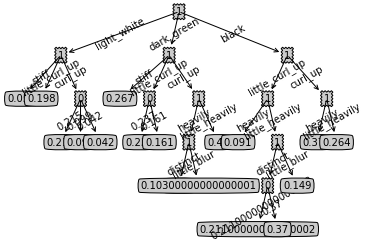

In [33]:
createPlot(myTree)